# 1. Importing relevant packages

In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 300)

# 2. Importing the data

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv("/kaggle/input/widsdatathon2022/train.csv", sep=',')
test = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv", sep=',')

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


In [4]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

# 3. First data inspection

In [5]:
print("Number of train samples are:",train.shape)
print("Number of test samples are:",test.shape) 

Number of train samples are: (75757, 64)
Number of test samples are: (9705, 63)


The training data set has 75'757 observations and 64 observed variables. One of them is the target variable (_site_eui_).
The test data set has 9'705 observations and 63 observed variables. Since the target has yet to be predicted, this data set contains one variable less.

In [6]:
# getting an overview of the variables, missing values and their data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [7]:
train.dtypes.value_counts()

int64      37
float64    24
object      3
dtype: int64

The observed variables consist of 61 numerical variables and 3 categorial variables. The latter have to be encoded in a later stage of the analyses in order to use them in the precition model.

In [8]:
categorical_features = ['Year_Factor','State_Factor', 'building_class', 'facility_type']
numerical_features=train.select_dtypes('number').columns

In [9]:
train.head(15)

Year_Factor State_Factor building_class  \
0             1      State_1     Commercial   
1             1      State_1     Commercial   
2             1      State_1     Commercial   
3             1      State_1     Commercial   
4             1      State_1     Commercial   
5             1      State_1     Commercial   
6             1      State_1     Commercial   
7             1      State_1     Commercial   
8             1      State_1     Commercial   
9             1      State_1     Commercial   
10            1      State_1     Commercial   
11            1      State_1     Commercial   
12            1      State_1     Commercial   
13            1      State_1     Commercial   
14            1      State_1     Commercial   

                                facility_type  floor_area  year_built  \
0                Grocery_store_or_food_market     61242.0      1942.0   
1   Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                        Retail_Enclosed_mall    280025.0      1951.0   
3                   Education_Other_classroom     55325.0      1980.0   
4                   Warehouse_Nonrefrigerated     66000.0      1985.0   
5                       Warehouse_Selfstorage    119900.0      1956.0   
6                   Warehouse_Nonrefrigerated     91367.0      1982.0   
7                   Warehouse_Nonrefrigerated     50422.0      1947.0   
8                        Office_Uncategorized    122020.0      1929.0   
9                        Office_Uncategorized    102612.0      1979.0   
10  Warehouse_Distribution_or_Shipping_center     65998.0      1979.0   
11                       Office_Uncategorized    100000.0      1927.0   
12                  Warehouse_Nonrefrigerated    128320.0      1960.0   
13                                Data_Center    616793.0      1955.0   
14                           Commercial_Other     53000.0      1924.0   

    energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                 11.0        2.4                36              50.5   
1                 45.0        1.8                36              50.5   
2                 97.0        1.8                36              50.5   
3                 46.0        1.8                36              50.5   
4                100.0        2.4                36              50.5   
5                  NaN        2.4                36              50.5   
6                 56.0        2.4                36              50.5   
7                 99.0        2.4                36              50.5   
8                 98.0        2.4                36              50.5   
9                 83.0        2.4                36              50.5   
10                51.0        2.4                36              50.5   
11                81.0        2.4                36              50.5   
12                29.0        2.4                36              50.5   
13                13.0        2.4                36              50.5   
14                 NaN        2.4                36              50.5   

    january_max_temp  february_min_temp  february_avg_temp  february_max_temp  \
0                 68                 35          50.589286                 73   
1                 68                 35          50.589286                 73   
2                 68                 35          50.589286                 73   
3                 68                 35          50.589286                 73   
4                 68                 35          50.589286                 73   
5                 68                 35          50.589286                 73   
6                 68                 35          50.589286                 73   
7                 68                 35          50.589286                 73   
8                 68                 35          50.589286                 73   
9                 68                 35          50.589286                 73   
10                68  

# 4. Exploration of the features

How much do the features correlate with the target?

In [10]:
train.corr()['site_eui'].sort_values()

energy_star_rating          -0.511012
january_min_temp            -0.179190
january_avg_temp            -0.167982
february_avg_temp           -0.154071
february_min_temp           -0.147348
march_avg_temp              -0.135303
march_min_temp              -0.134110
april_avg_temp              -0.113008
april_min_temp              -0.111528
february_max_temp           -0.106693
november_min_temp           -0.100349
january_max_temp            -0.097070
october_min_temp            -0.095334
avg_temp                    -0.089201
april_max_temp              -0.078969
november_avg_temp           -0.069882
march_max_temp              -0.064302
december_min_temp           -0.058888
days_with_fog               -0.055388
december_avg_temp           -0.050328
days_above_100F             -0.050029
Year_Factor                 -0.045179
october_avg_temp            -0.040162
june_max_temp               -0.029233
id                          -0.026500
days_above_110F             -0.014190
days_above_9

### a. Categorial variables

**Univariate exploration**

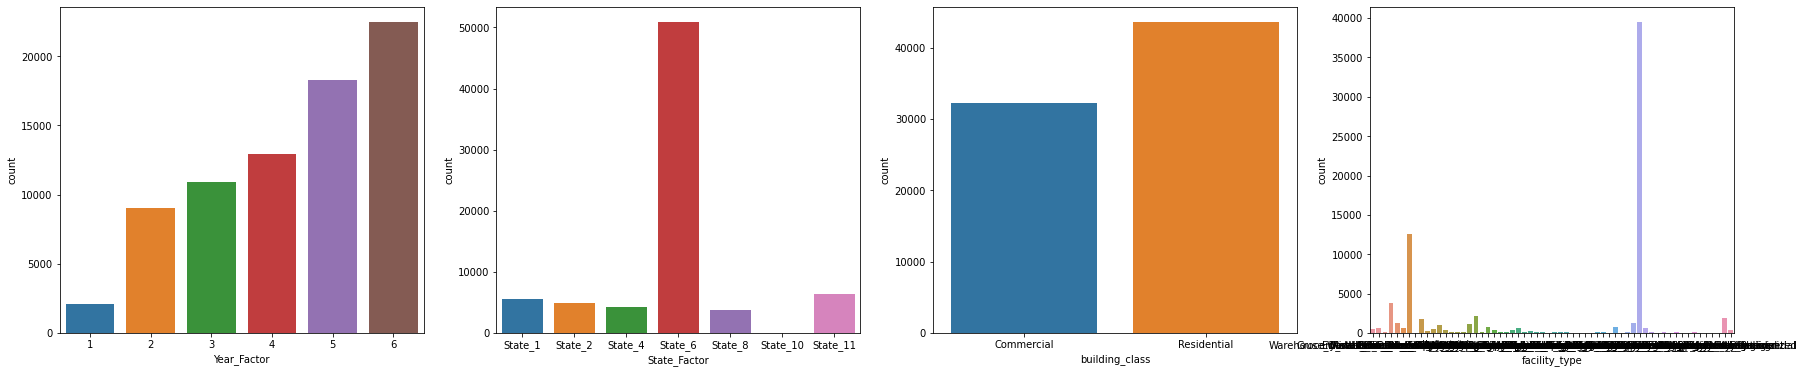

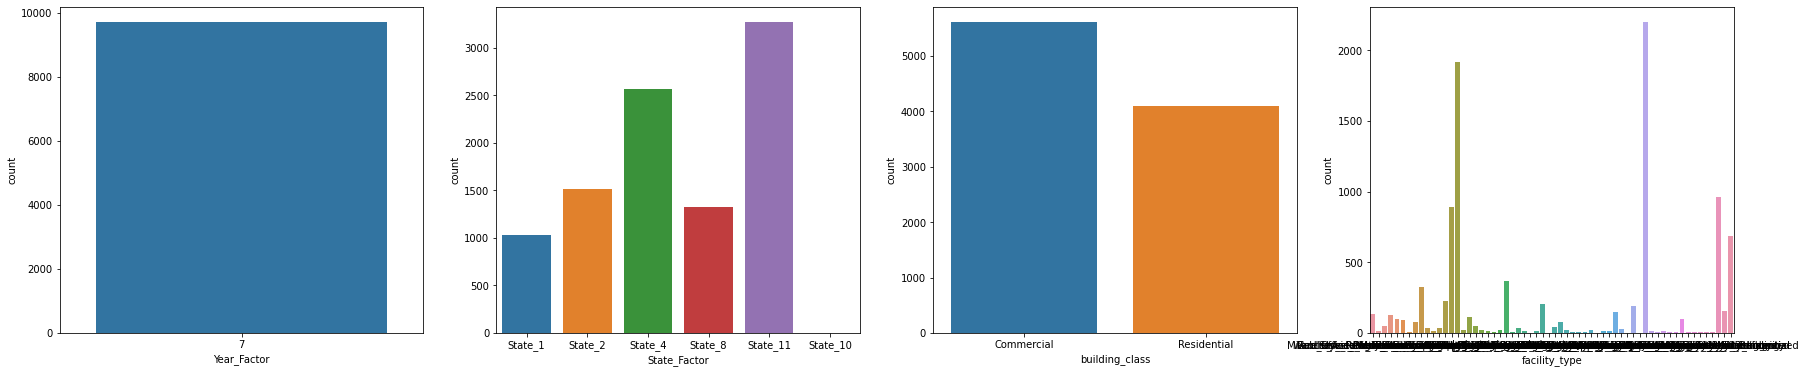

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.countplot(x=train[variable], ax=subplot)

fig, ax = plt.subplots(1, 4, figsize=(30, 6))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.countplot(x=test[variable], ax=subplot)

**Bivariate exploration with _site_eui_**

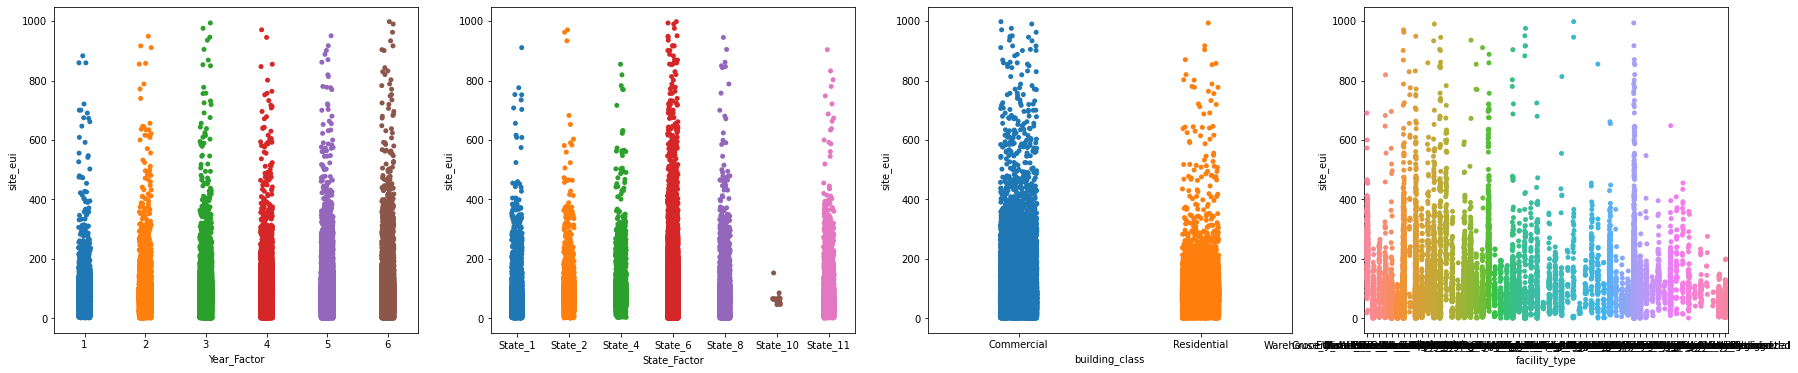

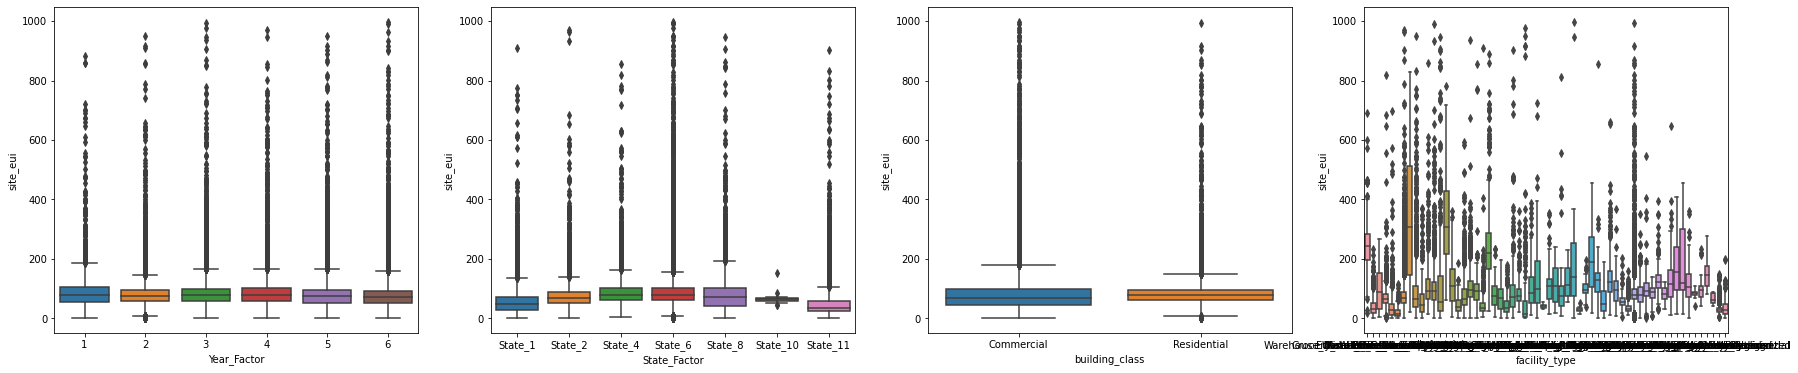

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.stripplot(x=train[variable],y=train['site_eui'], ax=subplot)
    
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.boxplot(x=train[variable],y=train['site_eui'], ax=subplot)

In [13]:
train.facility_type.value_counts()

Multifamily_Uncategorized                    39455
Office_Uncategorized                         12512
Education_Other_classroom                     3860
Lodging_Hotel                                 2098
2to4_Unit_Building                            1893
Commercial_Other                              1744
5plus_Unit_Building                           1273
Warehouse_Nonrefrigerated                     1255
Retail_Uncategorized                          1130
Education_College_or_university               1056
Nursing_Home                                   772
Education_Uncategorized                        709
Mixed_Use_Commercial_and_Residential           672
Lodging_Dormitory_or_fraternity_sorority       669
Warehouse_Distribution_or_Shipping_center      604
Warehouse_Selfstorage                          577
Grocery_store_or_food_market                   448
Office_Medical_non_diagnostic                  447
Health_Care_Inpatient                          409
Religious_worship              

The variable _facility_type_ seems to have a lot of different values and many of them are low in prevalence. That might cause two problems:
1. When encoding the variable in the later process we will create many new variables which might affect the efficiency of the model
2. Categories with low prevalence are badly represented. 

One Solution would be upsampling. However, especially for the very low prevelant categories we will inflate the observations. Instead, we will check whether we can collapse some of the categories.

In [14]:
train.groupby('facility_type').site_eui.describe()

count        mean         std  \
facility_type                                                                
2to4_Unit_Building                          1893.0   31.876915   15.384904   
5plus_Unit_Building                         1273.0   36.737785   17.063089   
Commercial_Other                            1744.0   92.642037   98.558043   
Commercial_Unknown                            95.0  113.151628   87.034282   
Data_Center                                   27.0  339.734876  245.512882   
Education_College_or_university             1056.0  108.629116   91.648618   
Education_Other_classroom                   3860.0   69.441531   34.194763   
Education_Preschool_or_daycare               108.0   60.974215   29.276360   
Education_Uncategorized                      709.0   46.172799   48.352653   
Food_Sales                                    70.0  136.793222  109.191997   
Food_Service_Other                            17.0   29.236616    8.863680   
Food_Service_Restaurant_or_cafeteria          64.0  195.593925  113.365447   
Food_Service_Uncategorized                    18.0  128.801496   61.991247   
Grocery_store_or_food_market                 448.0  241.135162   81.281971   
Health_Care_Inpatient                        409.0  248.340597  138.725991   
Health_Care_Outpatient_Clinic                 56.0  103.613131   64.348722   
Health_Care_Outpatient_Uncategorized          36.0  189.892345  128.033094   
Health_Care_Uncategorized                     51.0  183.945201  191.480790   
Industrial                                   384.0  125.345295  175.636635   
Laboratory                                   107.0  329.448470  157.183659   
Lodging_Dormitory_or_fraternity_sorority     669.0   81.595825   43.038184   
Lodging_Hotel                               2098.0  104.934997   52.299039   
Lodging_Other                                 75.0  120.958325   69.609905   
Lodging_Uncategorized                          5.0   66.595438   20.870048   
Mixed_Use_Commercial_and_Residential         672.0   89.529798   90.004386   
Mixed_Use_Predominantly_Commercial           256.0   69.133400   72.521419   
Mixed_Use_Predominantly_Residential            9.0   81.797872   19.563630   
Multifamily_Uncategorized                  39455.0   83.878522   38.620974   
Nursing_Home                                 772.0  131.313887   66.920704   
Office_Bank_or_other_financial               173.0   89.895736   57.268432   
Office_Medical_non_diagnostic                447.0  116.762294   92.977009   
Office_Mixed_use                              18.0   82.110316   24.562245   
Office_Uncategorized                       12512.0   77.074389   48.623970   
Parking_Garage                               251.0   67.351241  147.998741   
Public_Assembly_Drama_theater                 70.0   80.916723   54.367559   
Public_Assembly_Entertainment_culture        110.0  118.900412   84.589164   
Public_Assembly_Library                      160.0  105.849109   63.316513   
Public_Assembly_Movie_Theater                 39.0  103.095275   35.371933   
Public_Assembly_Other                        142.0  126.704295   84.500374   
Public_Assembly_Recreation                    72.0  115.177708   75.338672   
Public_Assembly_Social_meeting                88.0   78.921954   55.139649   
Public_Assembly_Stadium                        9.0  157.041663   62.107399   
Public_Assembly_Uncategorized                 25.0   62.872612   52.589482   
Public_Safety_Courthouse                      38.0  103.182163   47.652194   
Public_Safety_Fire_or_police_station         157.0  131.122766   54.801226   
Public_Safety_Penitentiary                    37.0  170.904892   99.710104   
Public_Safety_Uncategorized                   43.0   83.709161   28.866804   
Religious_worship                            399.0   44.560675   31.826133   
Retail_Enclosed_mall                         120.0  100.965937   73.654135   
Retail_Strip_shopping_mall                   113.0  110.418481  124

### b. Numerical variables

**Building characteristics**

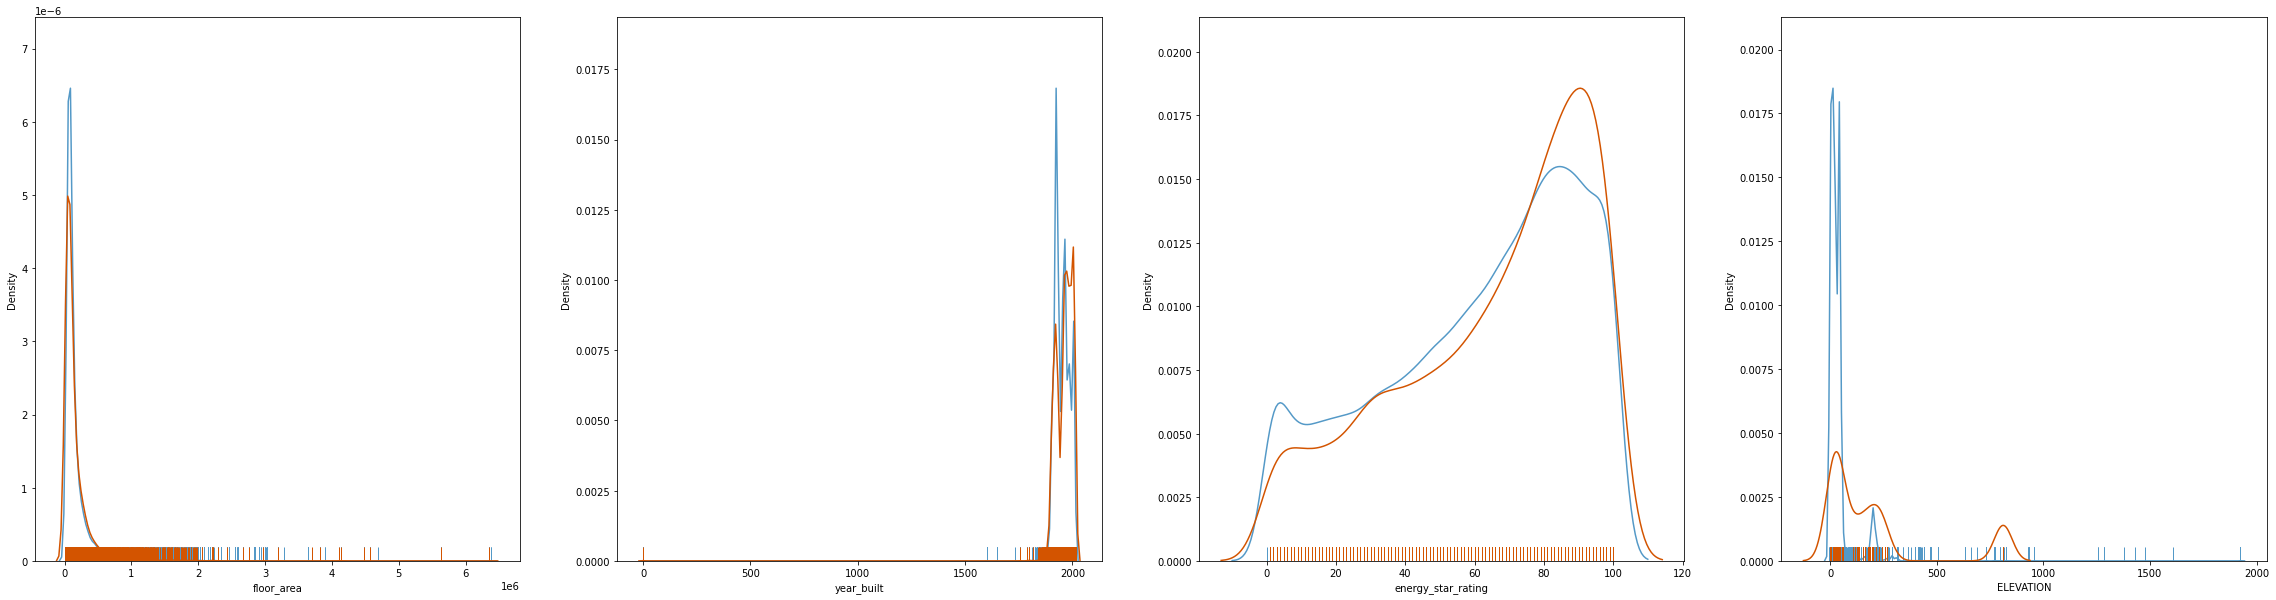

In [15]:
building = ['floor_area','year_built','energy_star_rating','ELEVATION']

fig, ax = plt.subplots(1,4, figsize=(40, 10))
for variable, subplot in zip(building, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot)  # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

This variables seem to have some outliers. Let's visualize using boxplots.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

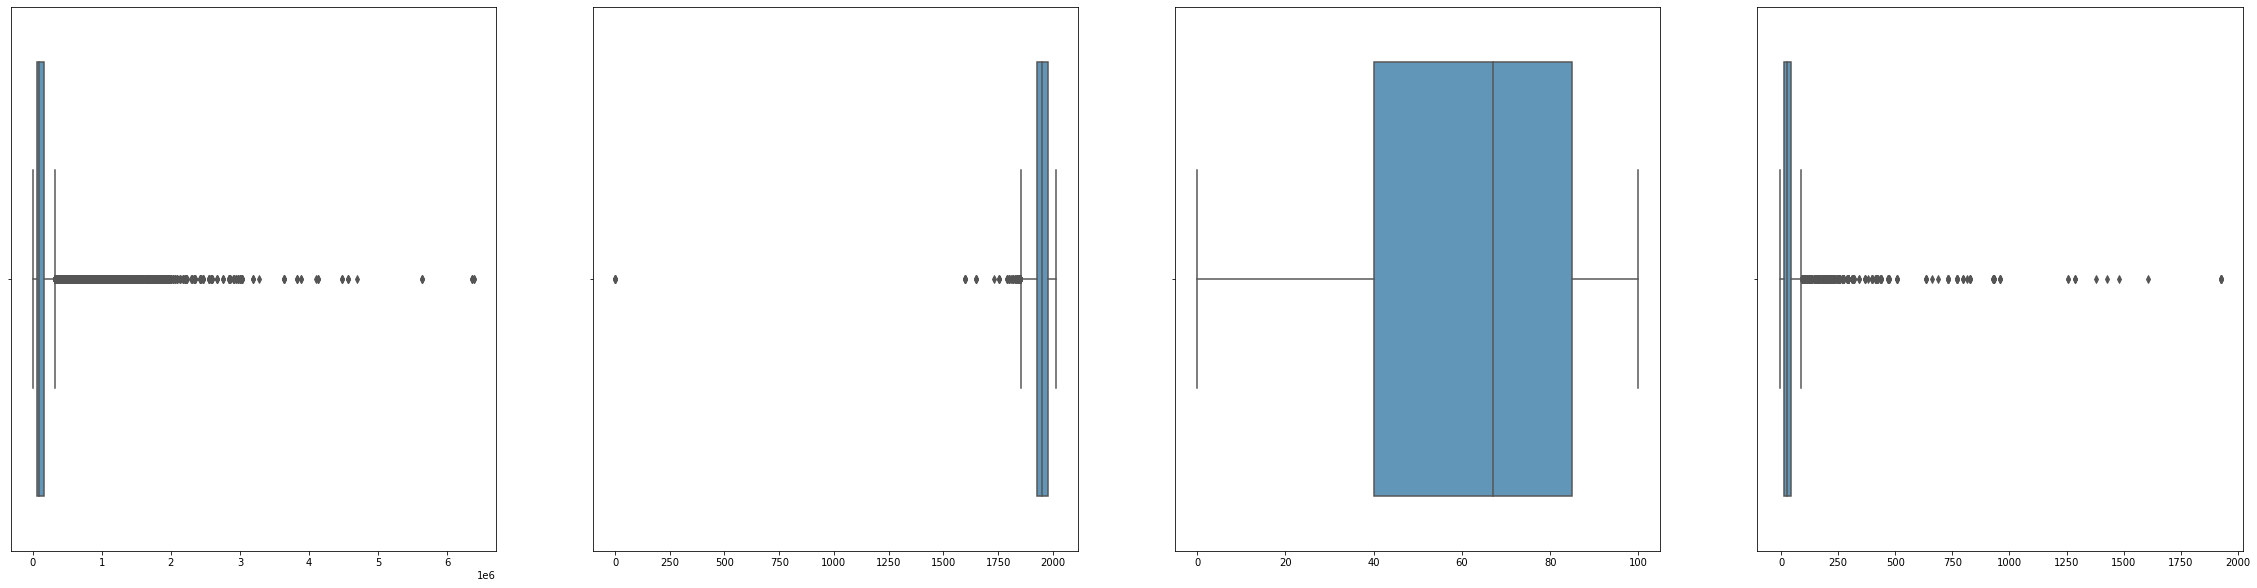

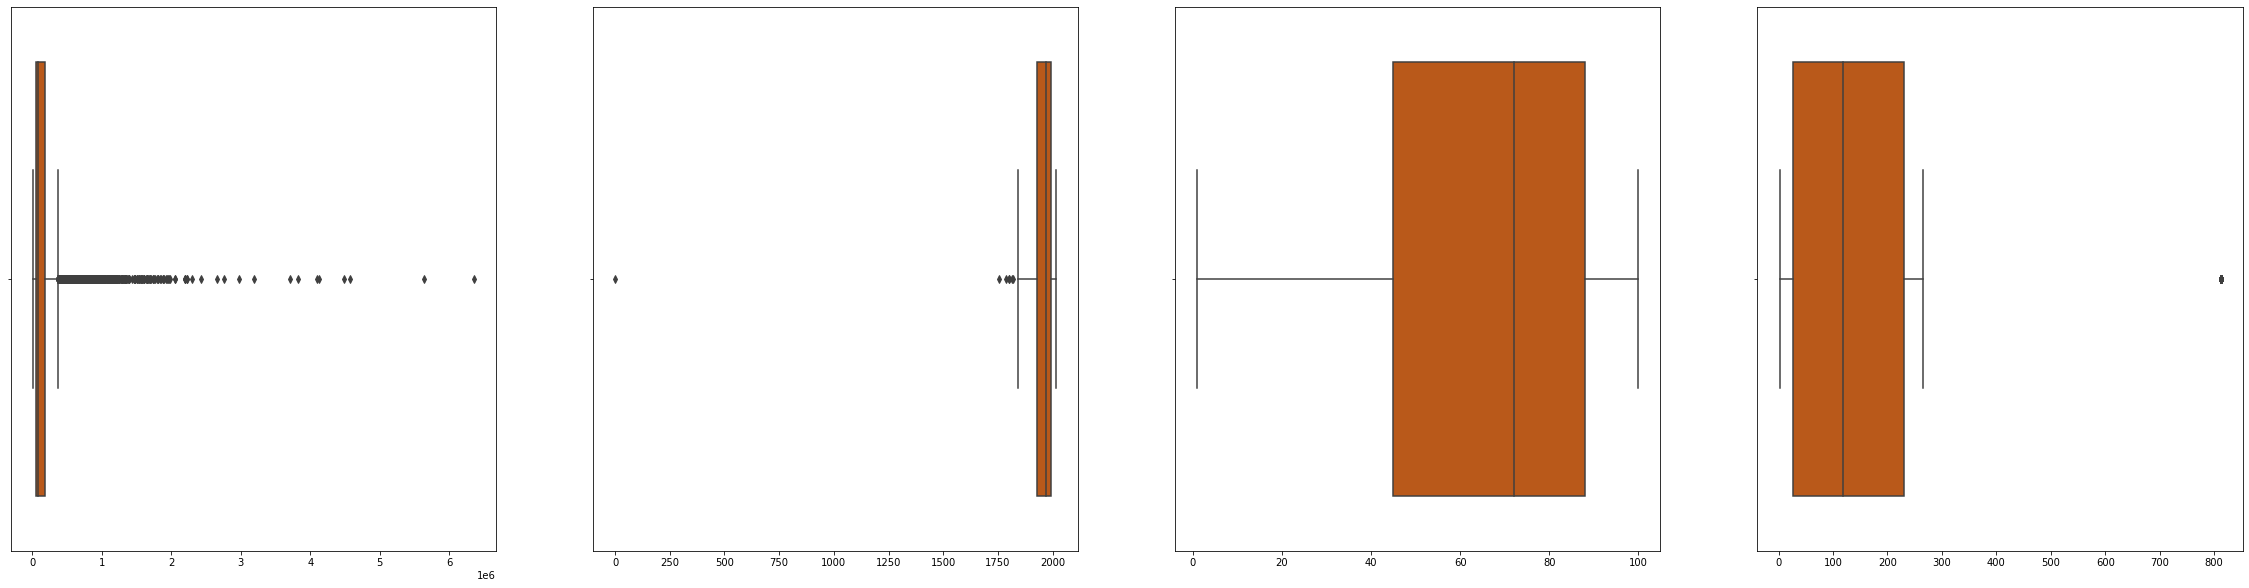

In [16]:
fig, ax = plt.subplots(1,4, figsize=(40, 10))
for variable, subplot in zip(building, ax.flatten()):
    sns.boxplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot)  # blue = train

fig, ax = plt.subplots(1,4, figsize=(40, 10))
for variable, subplot in zip(building, ax.flatten()):
    sns.boxplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test

Some observations of _year_built_ are zero. These must be errors and we will replace the values with NAN and to later be able to impute them with more reasonable values.


In [17]:
print('Year built equals zero, training data: ', list(train[train.year_built == 0].year_built.value_counts())[0])
print('Year built equals zero, training data: ', list(test[train.year_built == 0].year_built.value_counts())[0])

Year built equals zero, training data:  6
Year built equals zero, training data:  1


Boolean Series key will be reindexed to match DataFrame index.


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

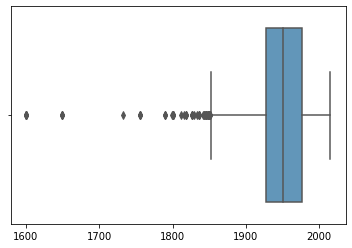

In [18]:
train_processed = train
train_processed.year_built.replace(0,np.nan,inplace=True)

sns.boxplot(train_processed['year_built'].to_numpy(), color = '#5499C7') # red = test

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

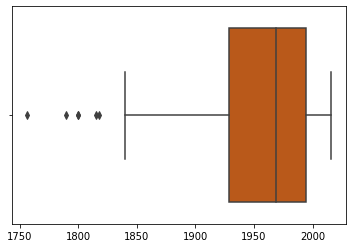

In [19]:
test_processed = test
test_processed.year_built.replace(0,np.nan,inplace=True)

sns.boxplot(test_processed['year_built'].to_numpy(), color = '#D35400') # red = test

**Monthly average temperature**

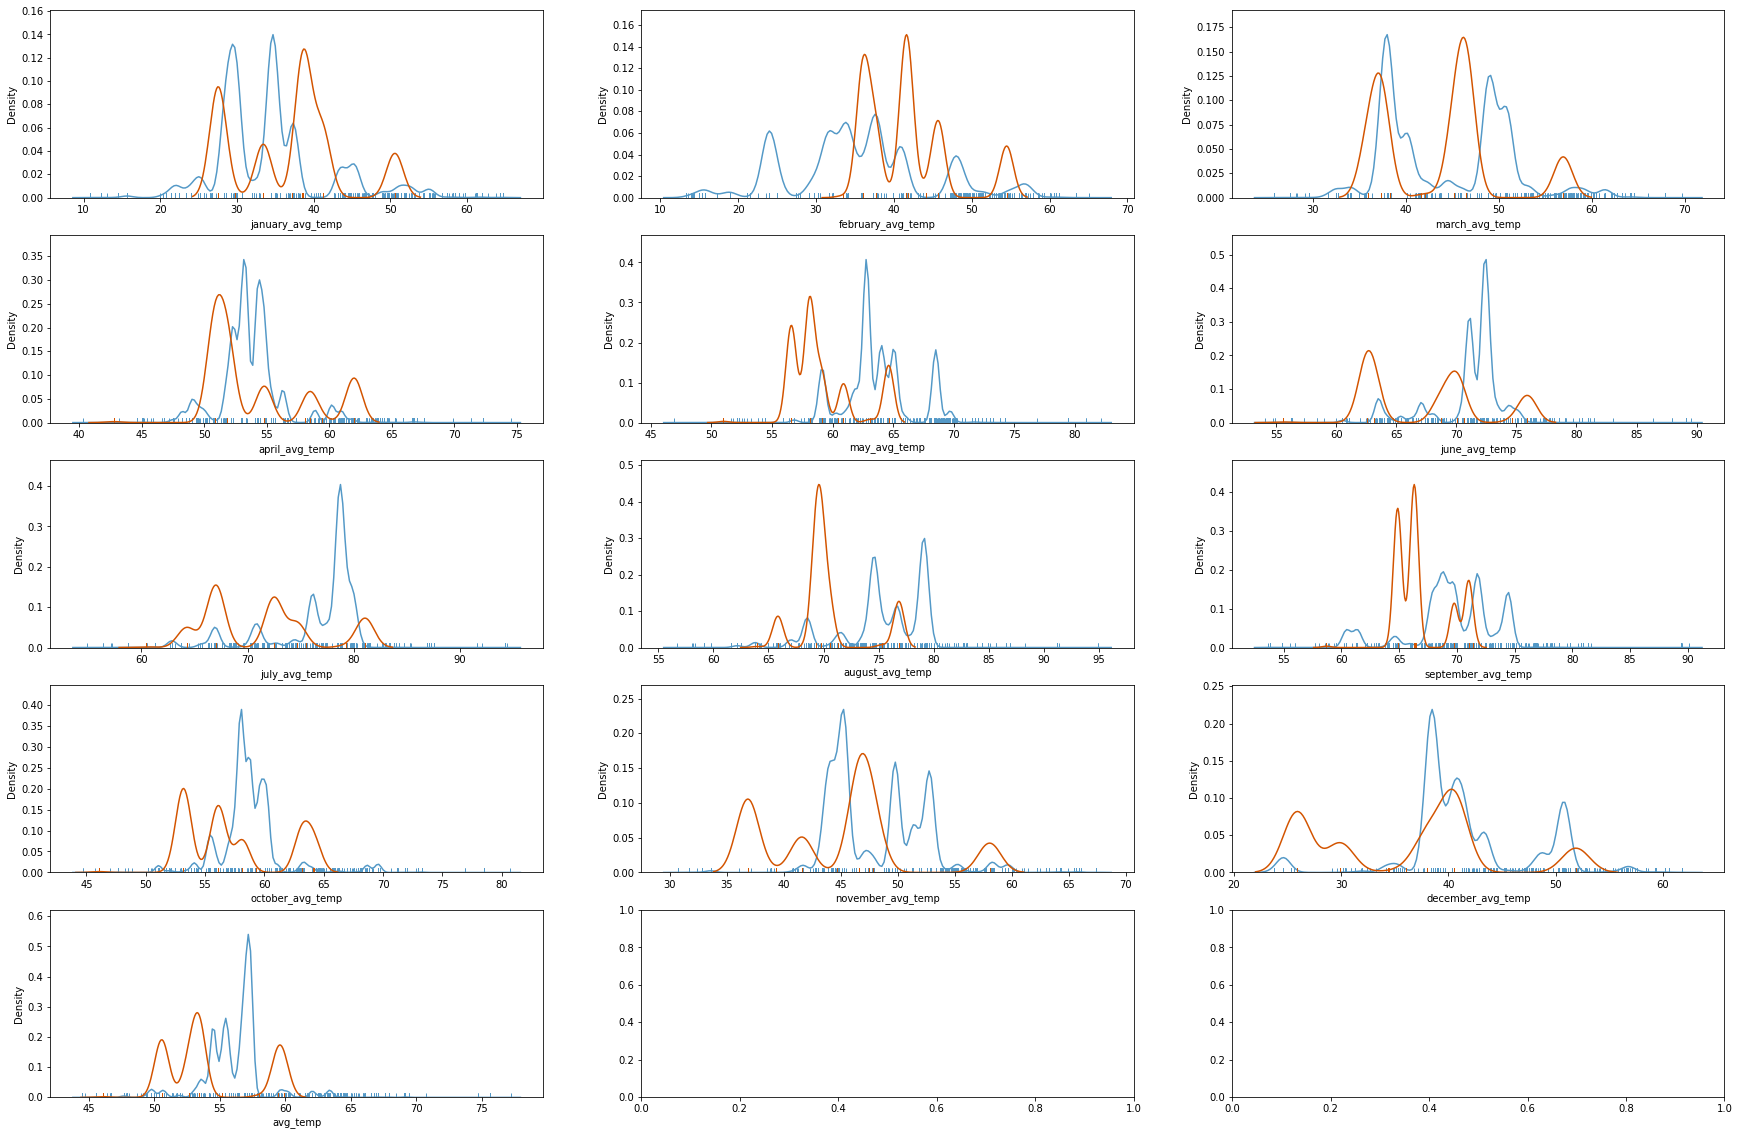

In [20]:
month_avg_temp = ['january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp',
'may_avg_temp', 'june_avg_temp', 'july_avg_temp', 'august_avg_temp',
'september_avg_temp', 'october_avg_temp', 'november_avg_temp','december_avg_temp','avg_temp']

fig, ax = plt.subplots(5,3, figsize=(30, 20))
for variable, subplot in zip(month_avg_temp, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot)  # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

**Monthly minimum temperature**

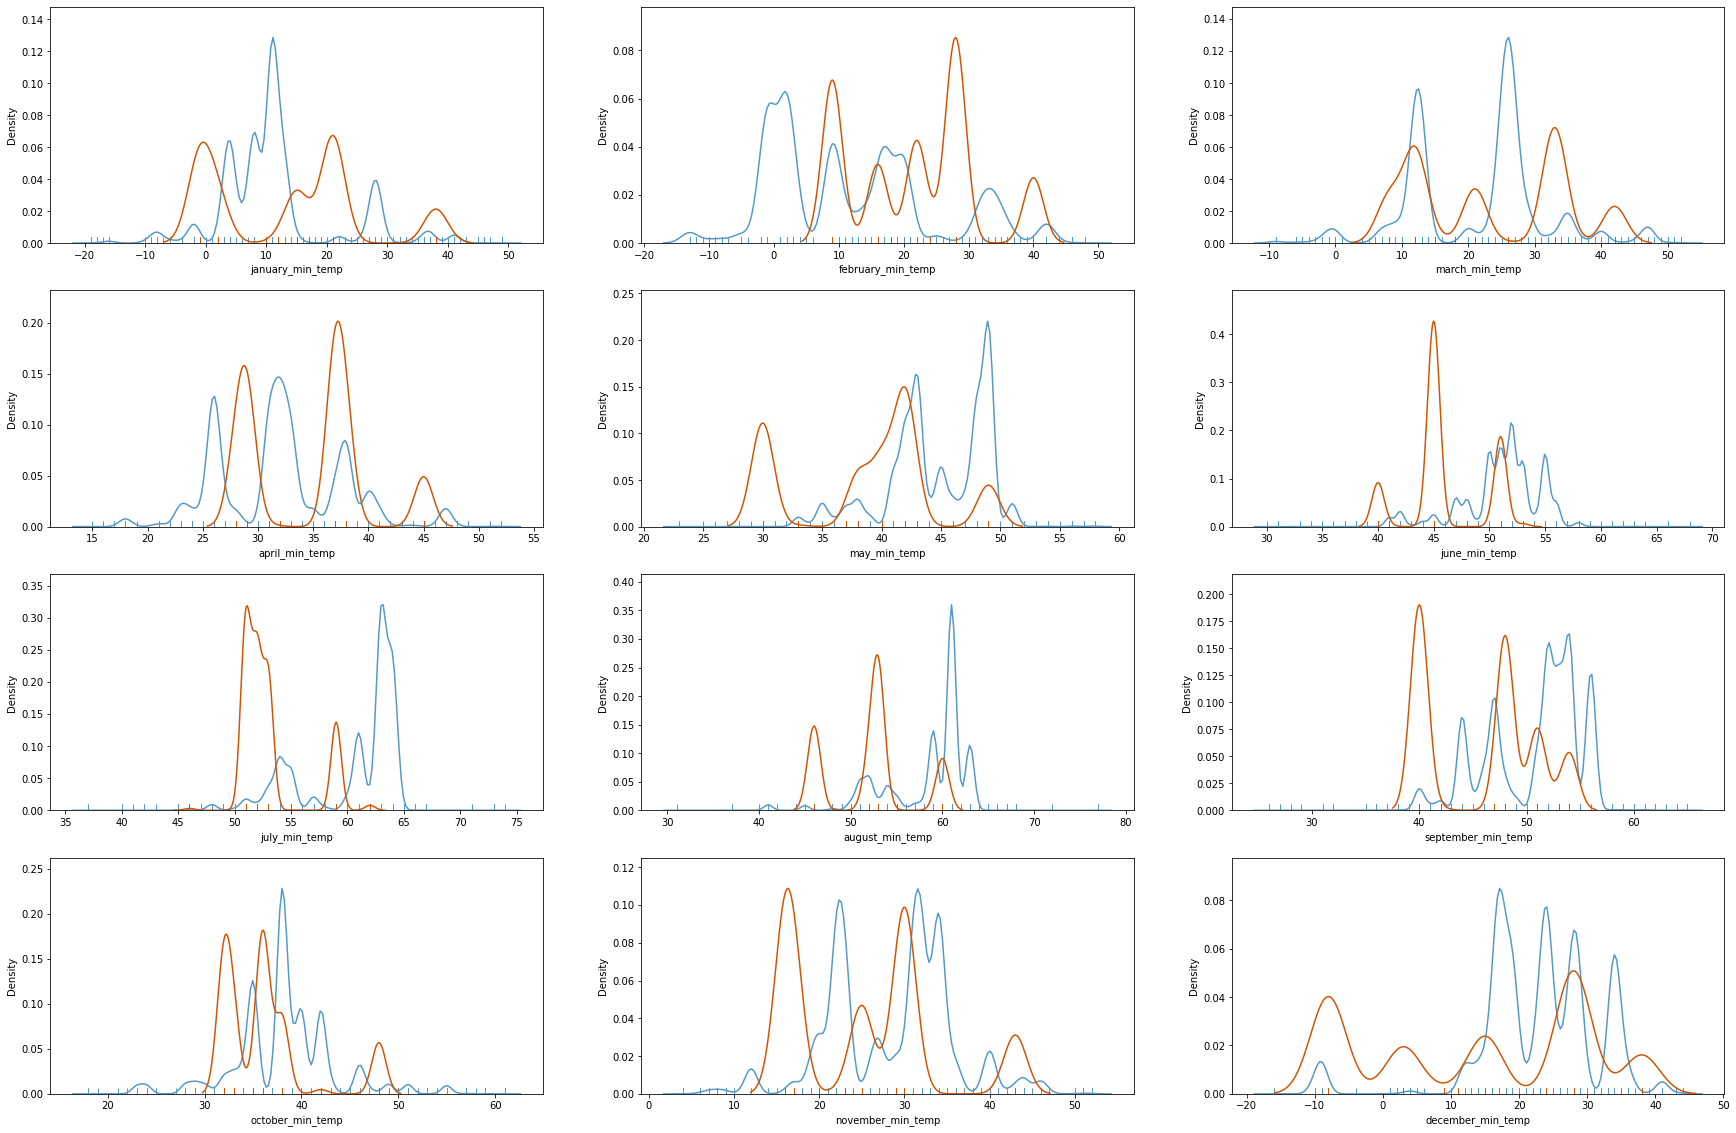

In [21]:
month_min_temp = ['january_min_temp','february_min_temp','march_min_temp','april_min_temp','may_min_temp', 'june_min_temp', 'july_min_temp', 'august_min_temp',
'september_min_temp', 'october_min_temp', 'november_min_temp','december_min_temp']


fig, ax = plt.subplots(4,3, figsize=(30, 20))
for variable, subplot in zip(month_min_temp, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot)  # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

**Monthly maximum temperature**

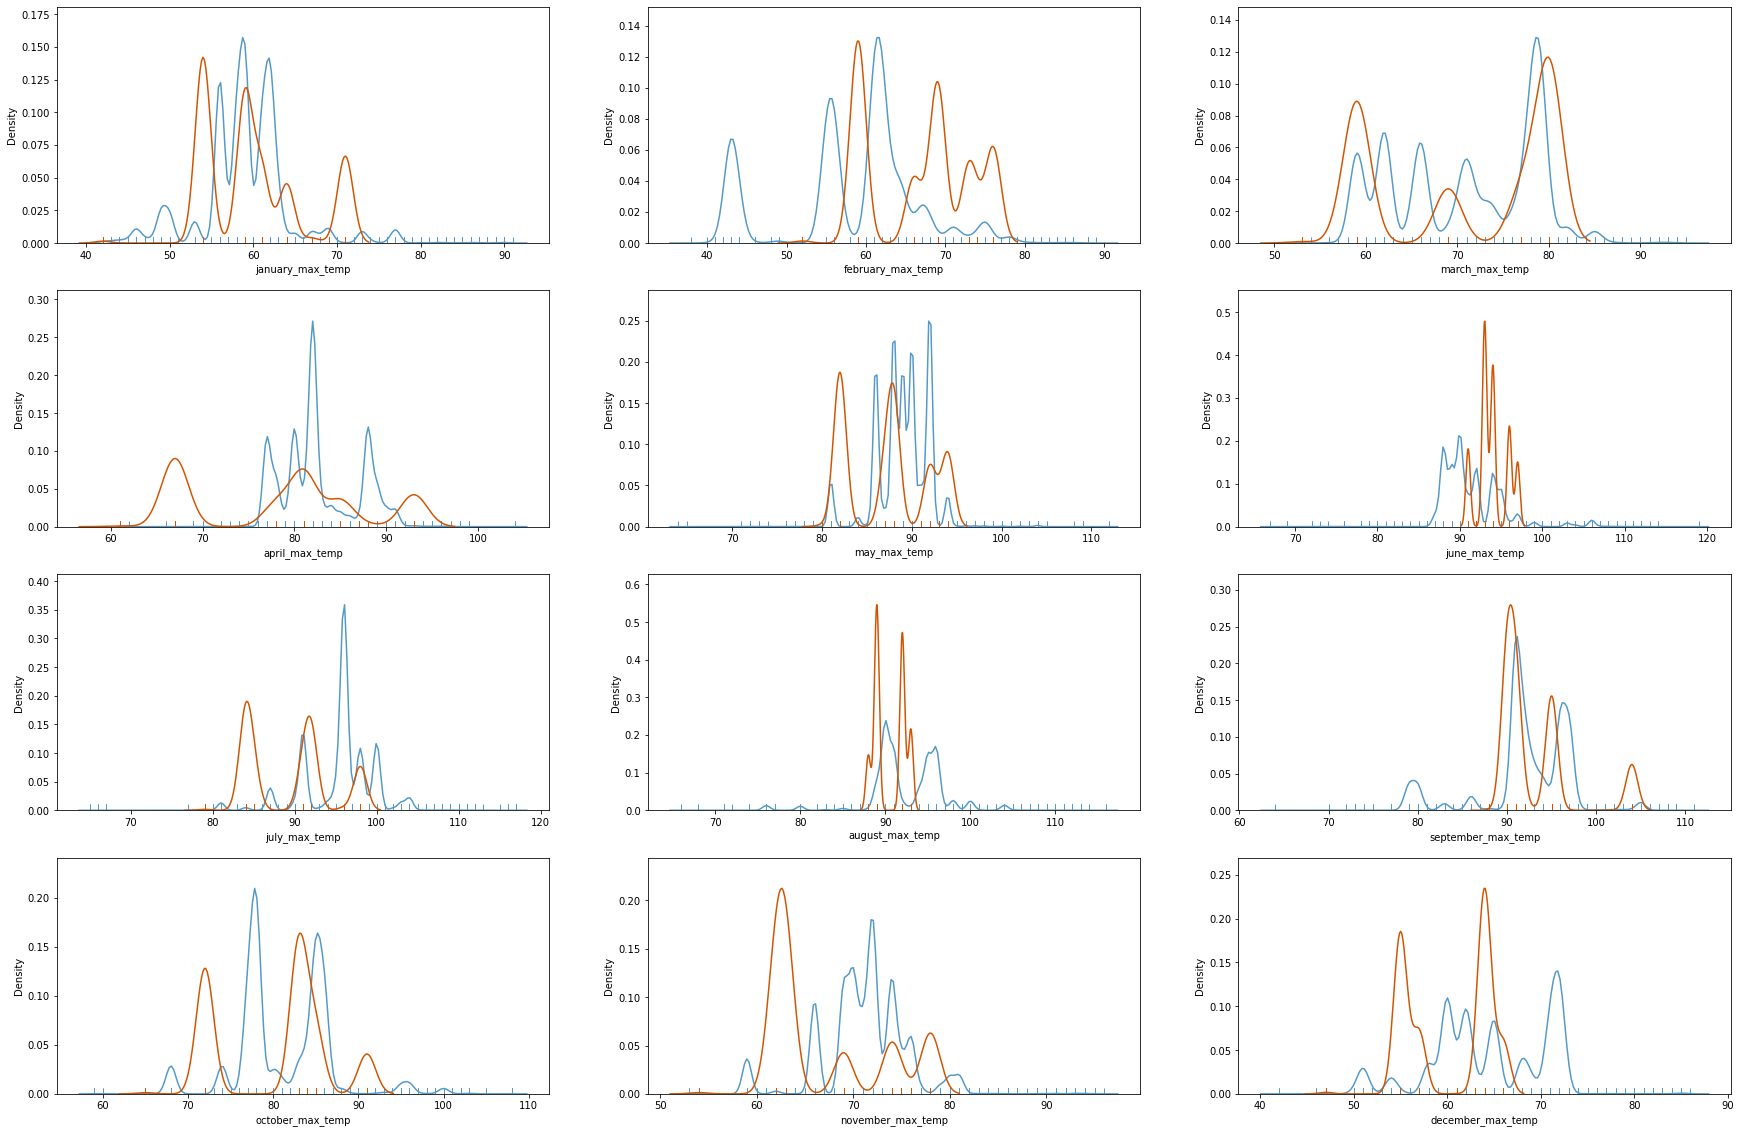

In [22]:
month_max_temp = ['january_max_temp','february_max_temp','march_max_temp','april_max_temp','may_max_temp', 'june_max_temp', 'july_max_temp', 'august_max_temp',
'september_max_temp', 'october_max_temp', 'november_max_temp','december_max_temp']


fig, ax = plt.subplots(4,3, figsize=(30, 20))
for variable, subplot in zip(month_max_temp, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot) # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot)  # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

**Days with extreme weather**

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


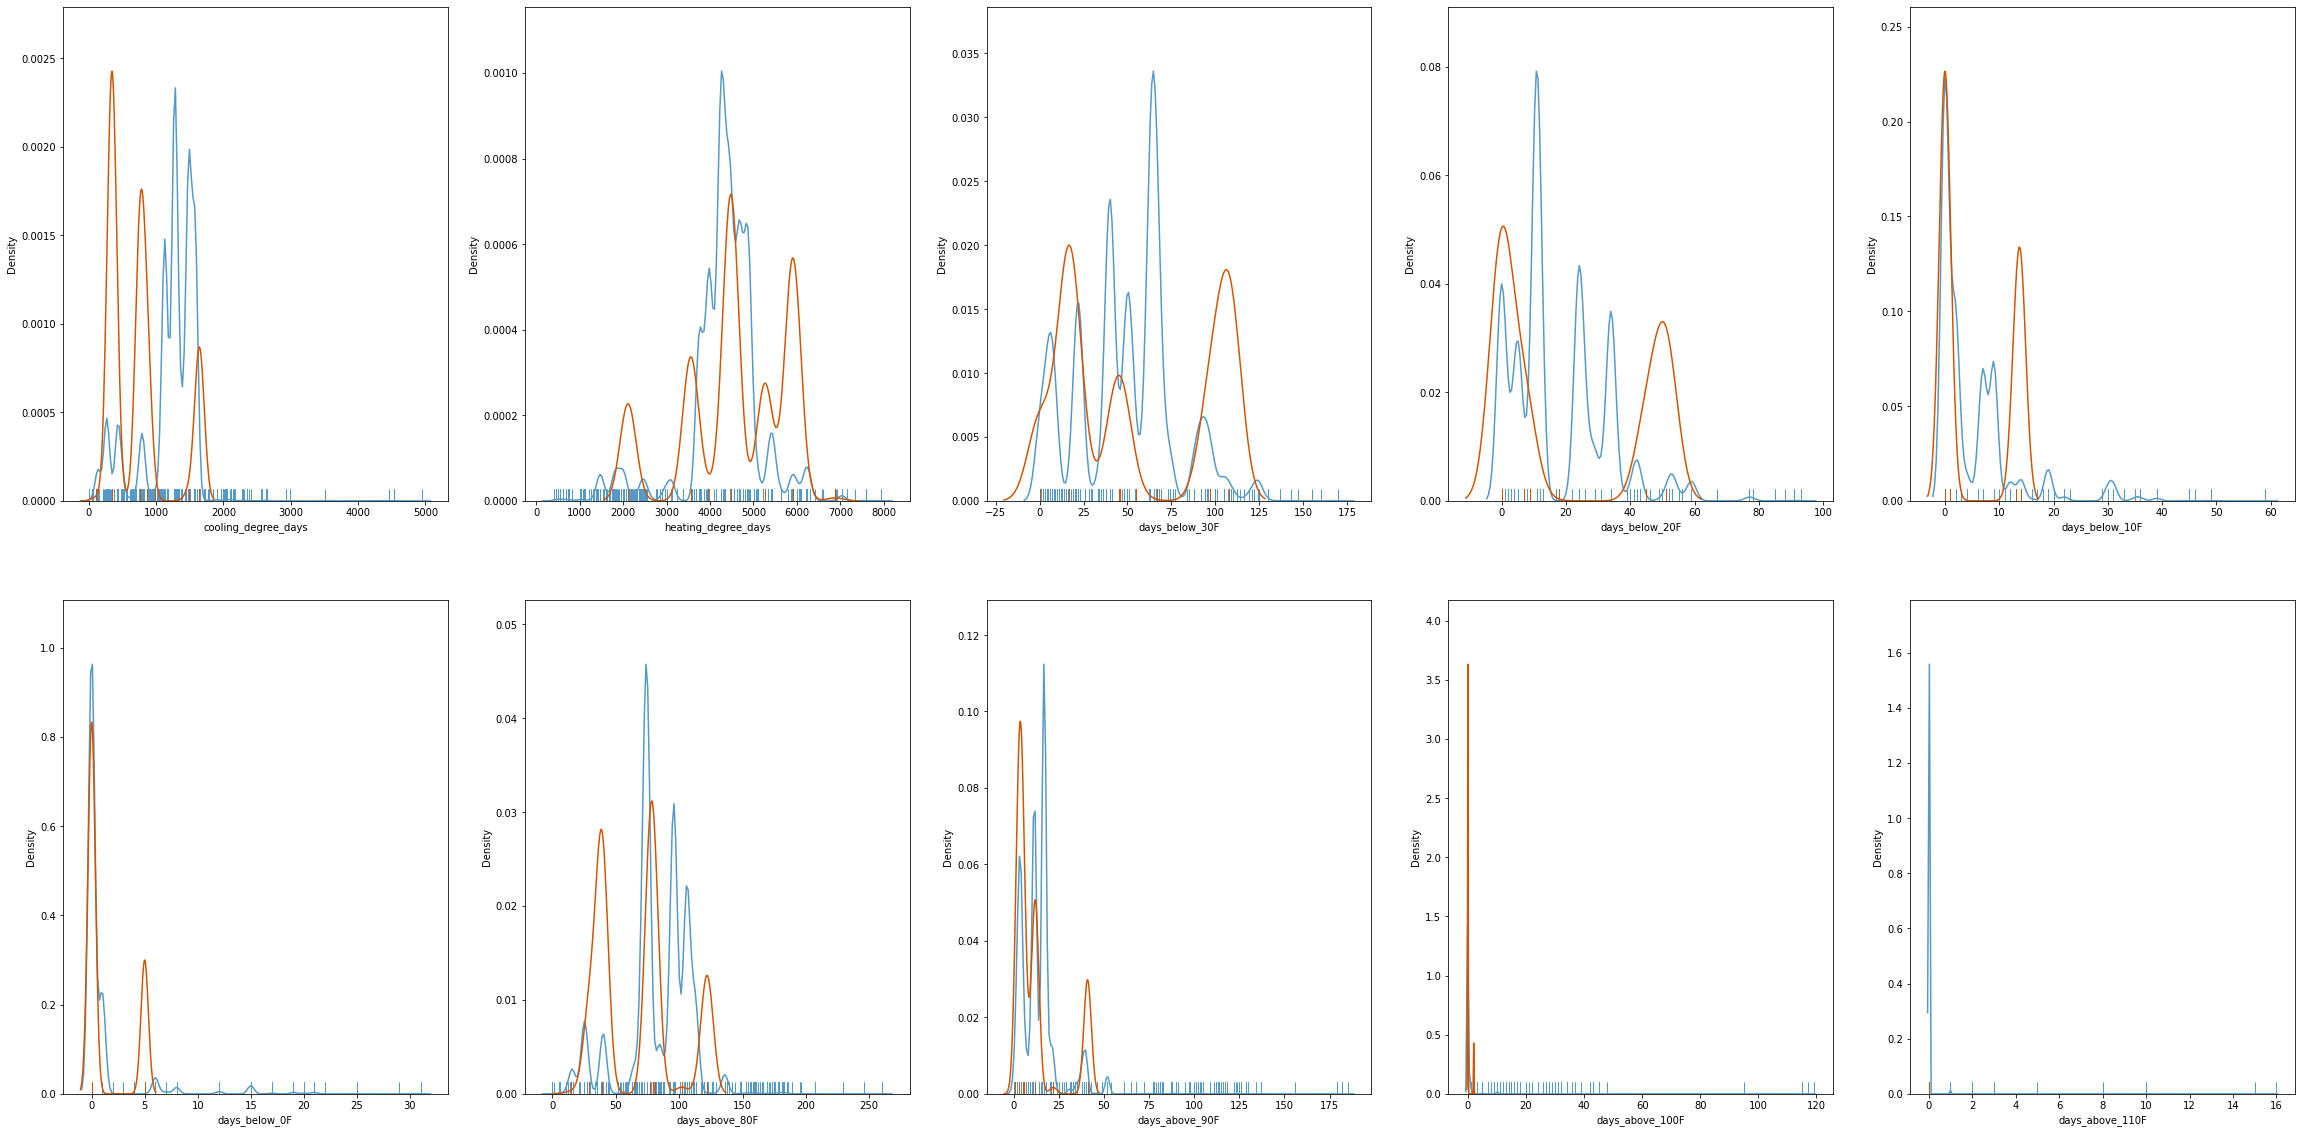

In [23]:
extreme_days= ['cooling_degree_days','heating_degree_days','days_below_30F','days_below_20F','days_below_10F','days_below_0F','days_above_80F','days_above_90F','days_above_100F','days_above_110F']

fig, ax = plt.subplots(2,5, figsize=(40, 20))
for variable, subplot in zip(extreme_days, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot) # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

In [24]:
train[extreme_days].describe()

cooling_degree_days  heating_degree_days  days_below_30F  \
count         75757.000000         75757.000000    75757.000000   
mean           1202.250446          4324.957390       48.756511   
std             391.561780           824.366727       27.587124   
min               0.000000           398.000000        0.000000   
25%            1128.000000          3978.000000       22.000000   
50%            1277.000000          4337.000000       50.000000   
75%            1489.000000          4670.000000       66.000000   
max            4948.000000          7929.000000      170.000000   

       days_below_20F  days_below_10F  days_below_0F  days_above_80F  \
count    75757.000000    75757.000000   75757.000000    75757.000000   
mean        17.447932        4.886532       0.876764       82.709809   
std         14.469435        7.071221       2.894244       25.282913   
min          0.000000        0.000000       0.000000        0.000000   
25%          5.000000        0.000000       0.000000       72.000000   
50%         11.000000        2.000000       0.000000       84.000000   
75%         26.000000        7.000000       0.000000       97.000000   
max         93.000000       59.000000      31.000000      260.000000   

       days_above_90F  days_above_100F  days_above_110F  
count    75757.000000     75757.000000     75757.000000  
mean        14.058701         0.279539         0.002442  
std         10.943996         2.252323         0.142140  
min          0.000000         0.000000         0.000000  
25%          6.000000         0.000000         0.000000  
50%         12.000000         0.000000         0.000000  
75%         17.000000         0.000000         0.000000  
max        185.000000       119.000000        16.000000

In [25]:
test[extreme_days].describe()

cooling_degree_days  heating_degree_days  days_below_30F  \
count          9705.000000          9705.000000     9705.000000   
mean            733.361875          4565.202061       54.256054   
std             452.168118          1165.539843       42.259933   
min             110.000000          2112.000000        0.000000   
25%             345.000000          3555.000000       17.000000   
50%             761.000000          4478.000000       45.000000   
75%             866.000000          5907.000000      108.000000   
max            1643.000000          6877.000000      108.000000   

       days_below_20F  days_below_10F  days_below_0F  days_above_80F  \
count     9705.000000     9705.000000    9705.000000     9705.000000   
mean        20.443895        5.371561       1.323029       66.820093   
std         23.182254        6.676871       2.205729       30.936872   
min          0.000000        0.000000       0.000000       15.000000   
25%          0.000000        0.000000       0.000000       39.000000   
50%          7.000000        0.000000       0.000000       77.000000   
75%         51.000000       14.000000       5.000000       79.000000   
max         51.000000       14.000000       5.000000      122.000000   

       days_above_90F  days_above_100F  days_above_110F  
count     9705.000000      9705.000000           9705.0  
mean        11.941267         0.211643              0.0  
std         13.077936         0.615250              0.0  
min          1.000000         0.000000              0.0  
25%          3.000000         0.000000              0.0  
50%          5.000000         0.000000              0.0  
75%         12.000000         0.000000              0.0  
max         41.000000         2.000000              0.0

We can remove _days_above_110F_ from the analyses since it does not have any variation in the test data. And we should also consider dropping _days_above_100F_ since it has very low variation in the test data.

In [26]:
train_processed = train_processed.drop(columns=['days_above_110F','days_above_100F'])
test_processed = test_processed.drop(columns=['days_above_110F','days_above_100F']);

In [27]:
test_processed.head()

Year_Factor State_Factor building_class                 facility_type  \
0            7      State_1     Commercial  Grocery_store_or_food_market   
1            7      State_1     Commercial  Grocery_store_or_food_market   
2            7      State_1     Commercial  Grocery_store_or_food_market   
3            7      State_1     Commercial  Grocery_store_or_food_market   
4            7      State_1     Commercial  Grocery_store_or_food_market   

   floor_area  year_built  energy_star_rating  ELEVATION  january_min_temp  \
0     28484.0      1994.0                37.0        2.4                38   
1     21906.0      1961.0                55.0       45.7                38   
2     16138.0      1950.0                 1.0       59.1                38   
3     97422.0      1971.0                34.0       35.4                38   
4     61242.0      1942.0                35.0        1.8                38   

   january_avg_temp  january_max_temp  february_min_temp  february_avg_temp  \
0         50.596774                64                 40          54.482143   
1         50.596774                64                 40          54.482143   
2         50.596774                64                 40          54.482143   
3         50.596774                64                 40          54.482143   
4         50.596774                64                 40          54.482143   

   february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                 66              42       56.935484              77   
1                 66              42       56.935484              77   
2                 66              42       56.935484              77   
3                 66              42       56.935484              77   
4                 66              42       56.935484              77   

   april_min_temp  april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0              45           58.45              78            49     60.903226   
1              45           58.45              78            49     60.903226   
2              45           58.45              78            49     60.903226   
3              45           58.45              78            49     60.903226   
4              45           58.45              78            49     60.903226   

   may_max_temp  june_min_temp  june_avg_temp  june_max_temp  july_min_temp  \
0            87             51          63.15             97             53   
1            87             51          63.15             97             53   
2            87             51          63.15             97             53   
3            87             51          63.15             97             53   
4            87             51          63.15             97             53   

   july_avg_temp  july_max_temp  august_min_temp  august_avg_temp  \
0      64.258065             85               53        65.854839   
1      64.258065             85               53        65.854839   
2      64.258065             85               53        65.854839   
3      64.258065             85               53        65.854839   
4      64.258065             85               53        65.854839   

   august_max_temp  september_min_temp  september_avg_temp  \
0               88                  54           69.766667   
1               88                  54           69.766667   
2               88                  54           69.766667   
3               88                  54           69.766667   
4               88                  54           69.766667   

   september_max_temp  october_min_temp  october_avg_temp  october_max_temp  \
0                 104                48         64.193548                91   
1                 104                48         64.193548                91   
2                 104                48         64.193548                91   
3                 104                48         64.193548                91   
4                 104   

In [28]:
print(train_processed.shape)
print(test_processed.shape)

(75757, 62)
(9705, 61)


**Other weather-related variables**

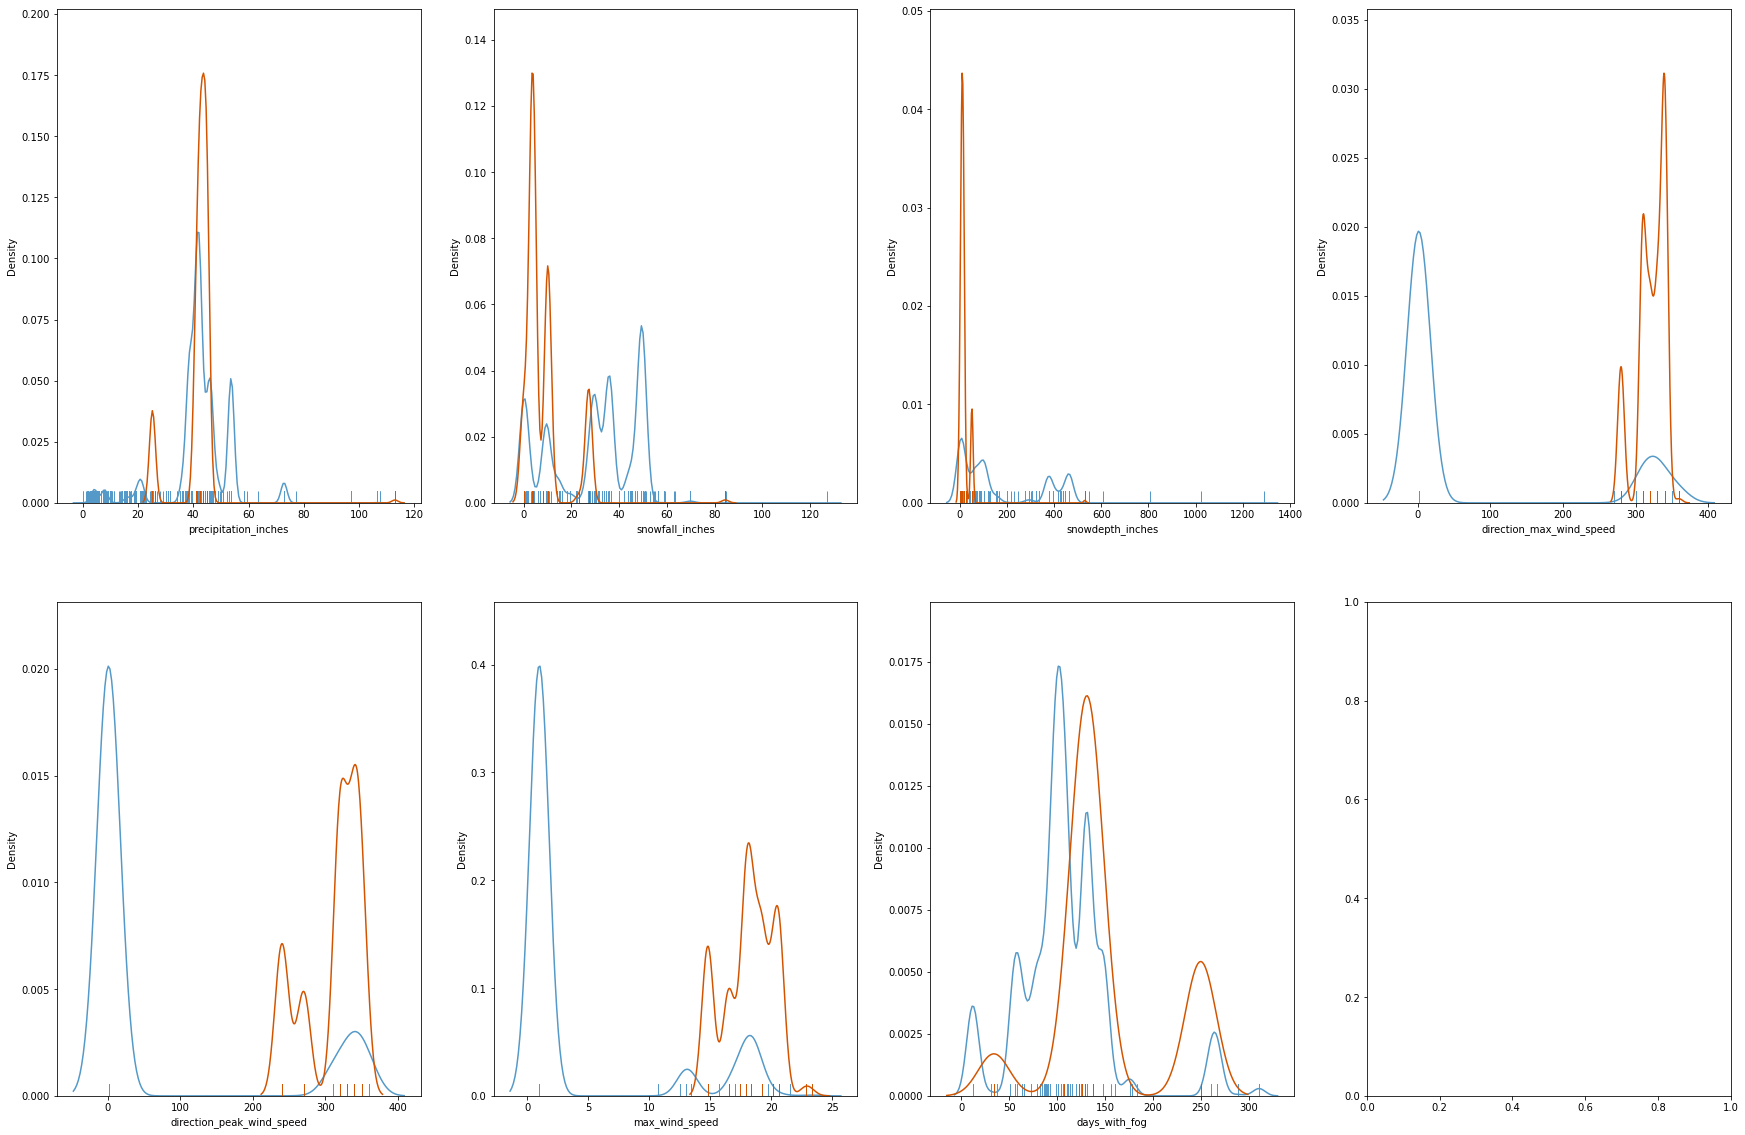

In [29]:
other_weather = ['precipitation_inches','snowfall_inches','snowdepth_inches','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']

fig, ax = plt.subplots(2,4, figsize=(30, 20))
for variable, subplot in zip(other_weather, ax.flatten()):
    sns.kdeplot(train[variable].to_numpy(), color = '#5499C7', ax=subplot) # blue = train
    sns.rugplot(train[variable], color = '#5499C7', ax=subplot)
    sns.kdeplot(test[variable].to_numpy(), color = '#D35400', ax=subplot) # red = test
    sns.rugplot(test[variable], color = '#D35400', ax=subplot)

### c. Correlation between the numerical features

**Building characteristics**

Text(0.5, 1.0, 'Correlation Heatmap Building Characteristics, train data')

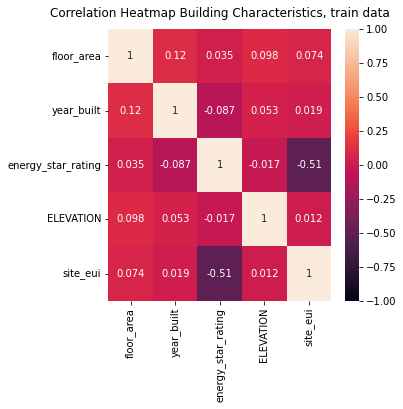

In [30]:
building.append('site_eui')
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(train[building].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Building Characteristics, train data', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Correlation Heatmap Building Characteristics, test data')

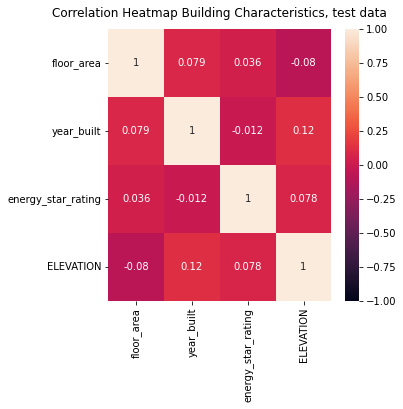

In [31]:
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(test[building[:4]].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Building Characteristics, test data', fontdict={'fontsize':12}, pad=12)

**Weather features**

Text(0.5, 1.0, 'Correlation Heatmap Weather Characteristics, train data')

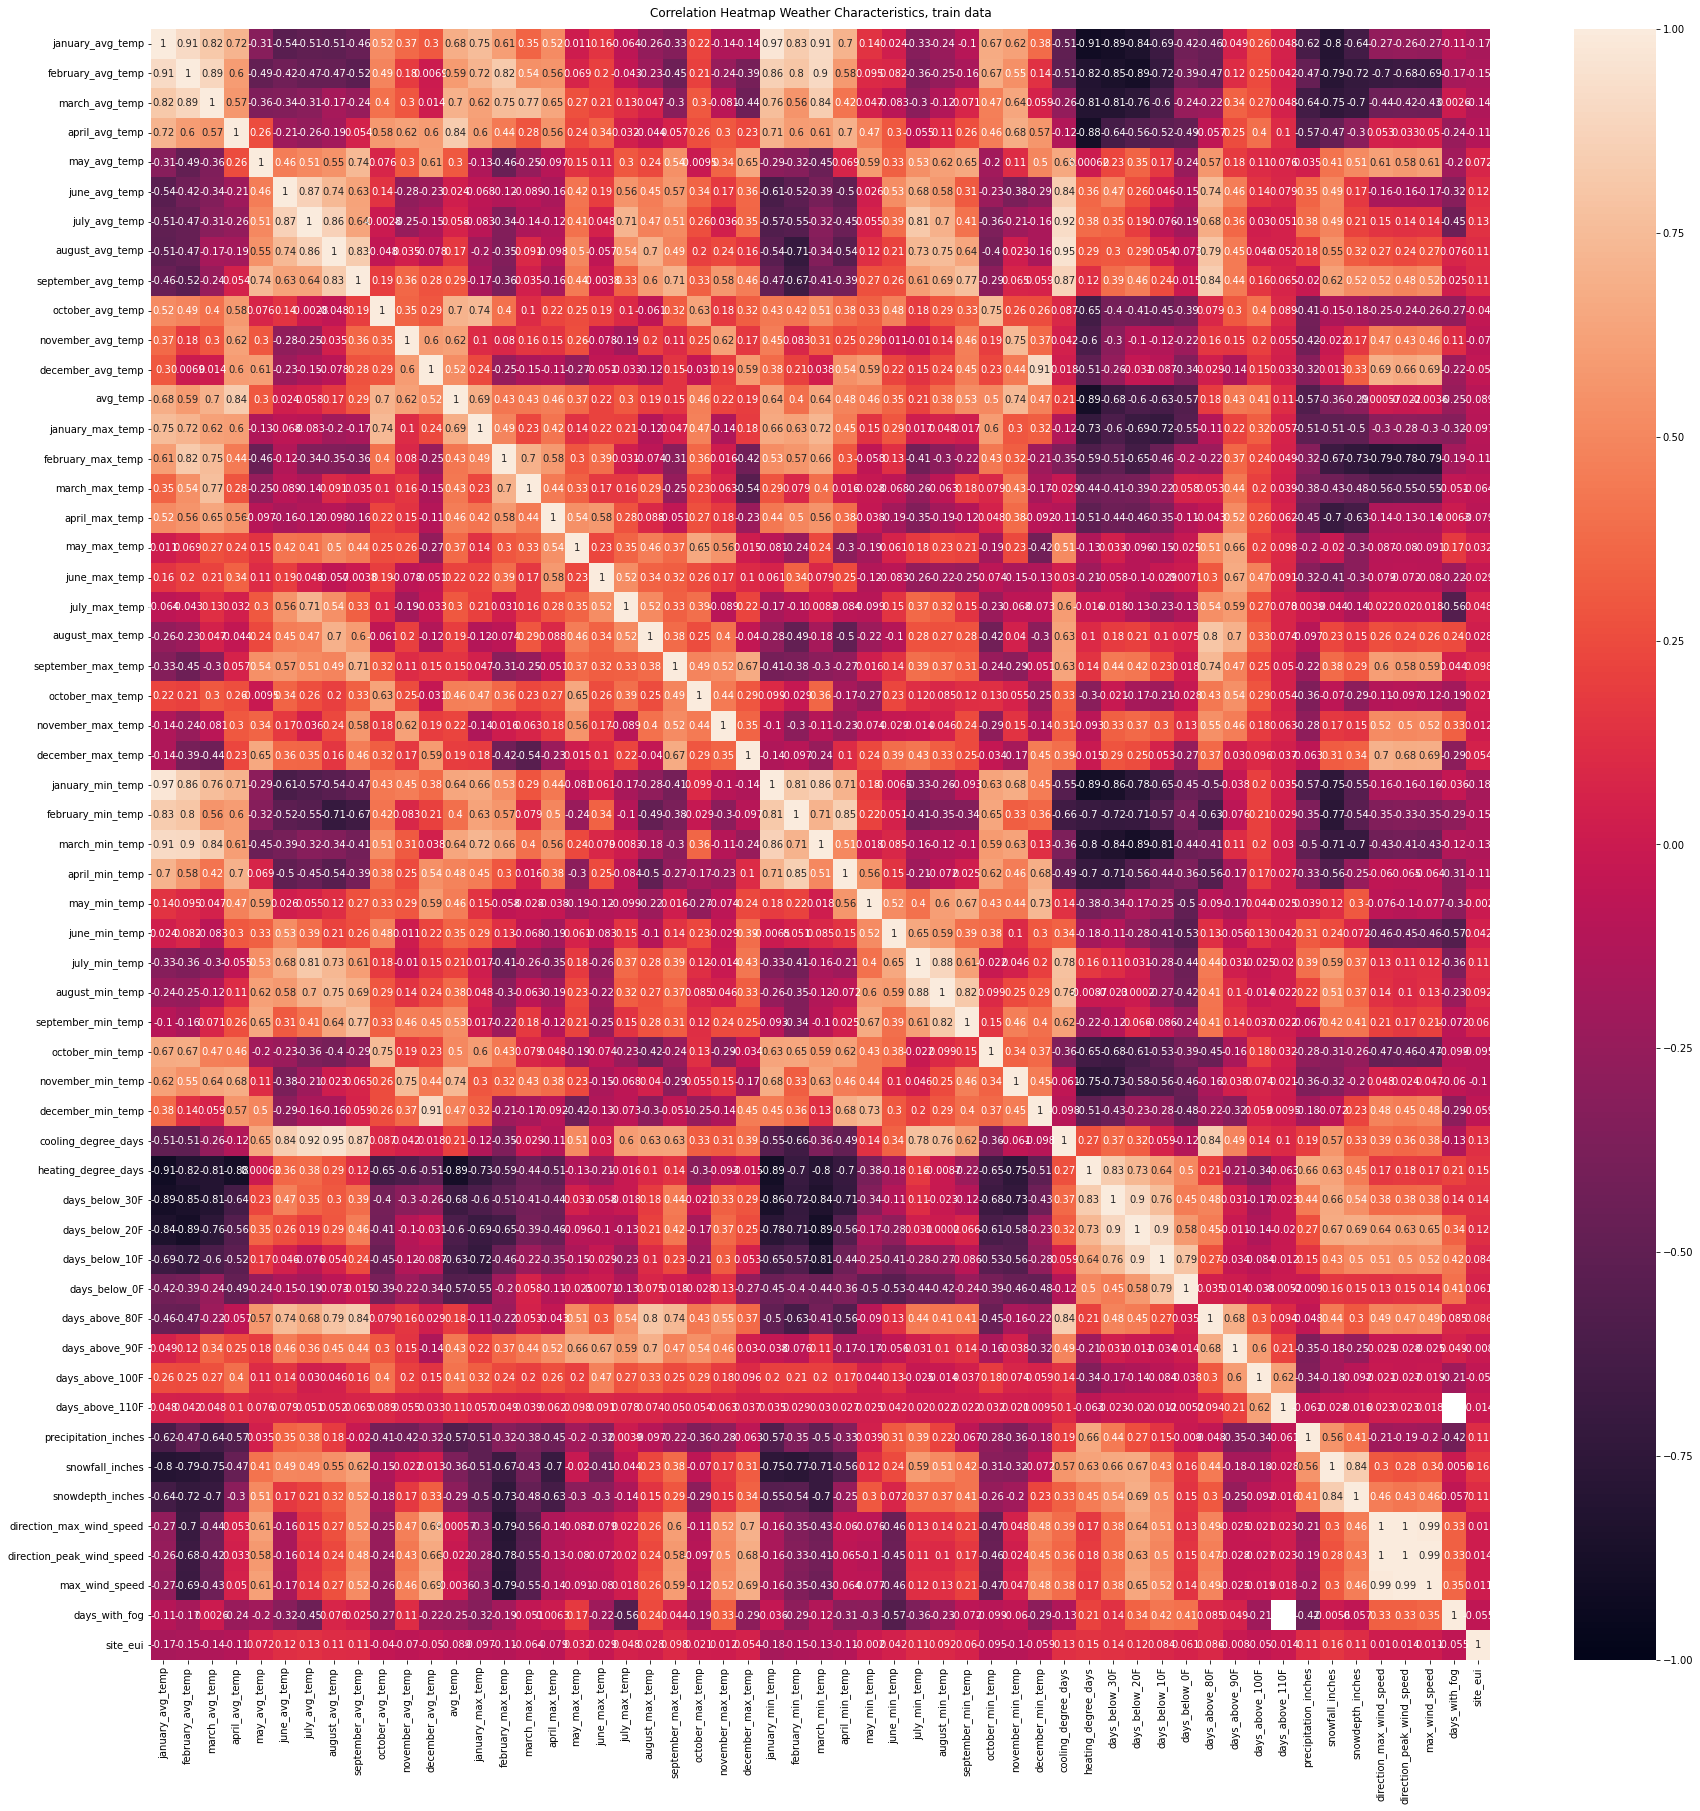

In [32]:
weather = ['january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp','may_avg_temp', 'june_avg_temp', 'july_avg_temp', 'august_avg_temp',
           'september_avg_temp', 'october_avg_temp', 'november_avg_temp','december_avg_temp','avg_temp','january_max_temp','february_max_temp','march_max_temp',
           'april_max_temp','may_max_temp', 'june_max_temp', 'july_max_temp', 'august_max_temp','september_max_temp', 'october_max_temp', 'november_max_temp','december_max_temp',
            'january_min_temp','february_min_temp','march_min_temp','april_min_temp','may_min_temp', 'june_min_temp', 'july_min_temp', 'august_min_temp','september_min_temp',
           'october_min_temp', 'november_min_temp','december_min_temp','cooling_degree_days','heating_degree_days','days_below_30F','days_below_20F','days_below_10F',
           'days_below_0F','days_above_80F','days_above_90F','days_above_100F','days_above_110F','precipitation_inches','snowfall_inches','snowdepth_inches',
           'direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog','site_eui']

plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(train[weather].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Weather Characteristics, train data', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Correlation Heatmap Weather Characteristics, test data')

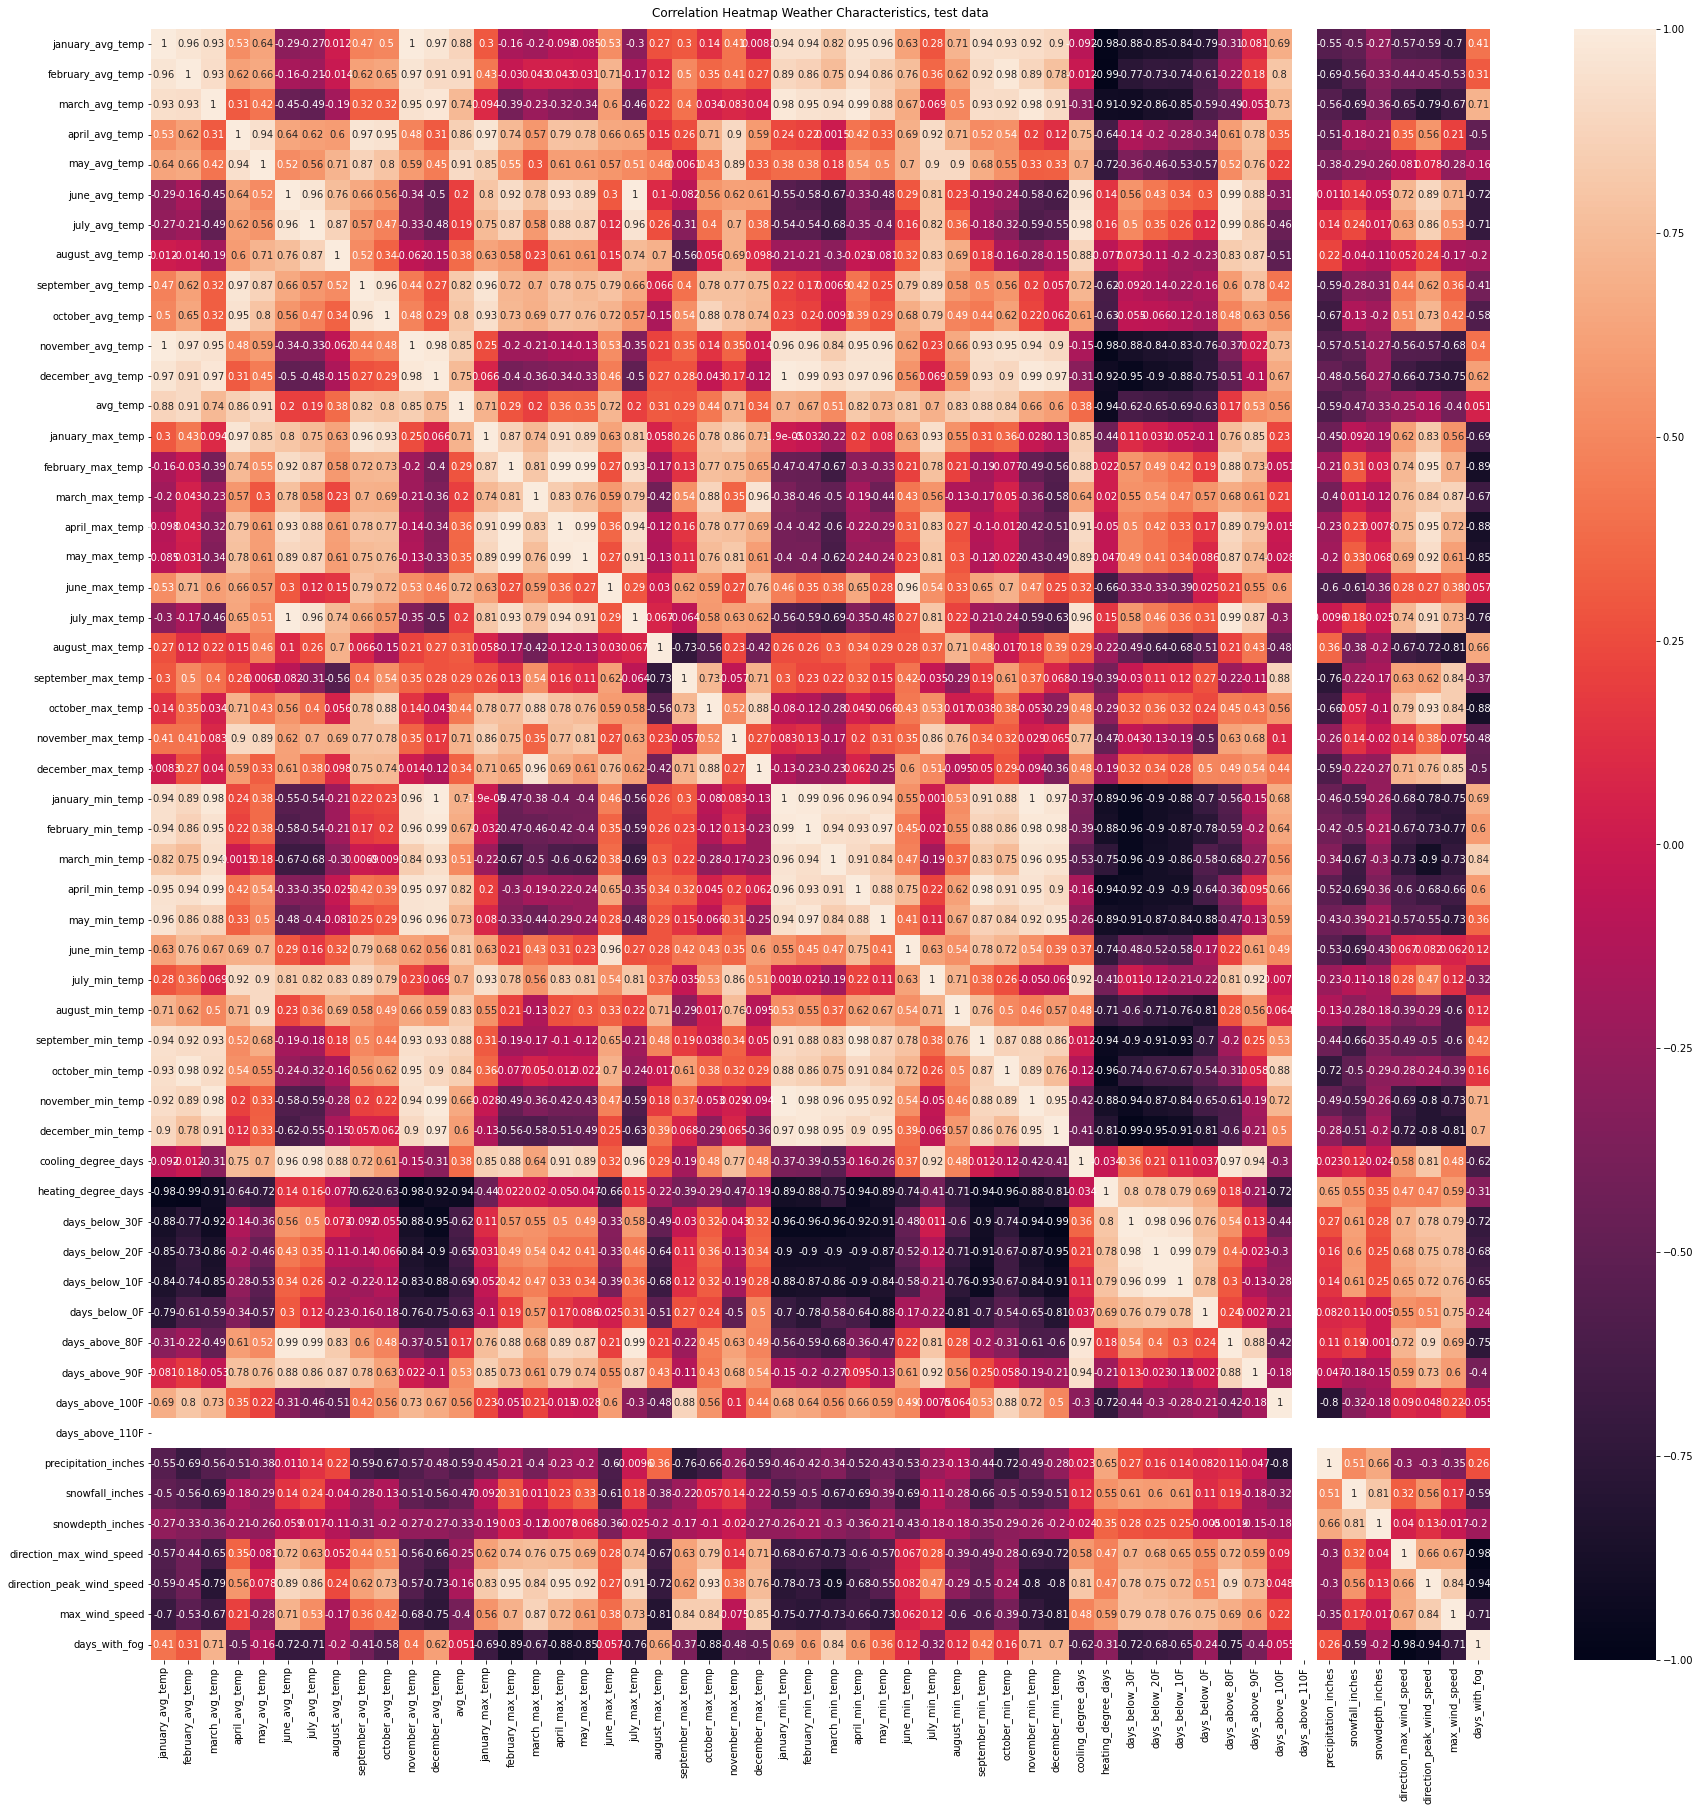

In [33]:
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(test[weather[:-1]].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Weather Characteristics, test data', fontdict={'fontsize':12}, pad=12)

**Listing variable that higly correlate with each other (abs > 0.9)**

In [34]:
correl_train = train[weather].corr()
correl_test = test[weather].corr()

KeyError: "['site_eui'] not in index"

In [ ]:
for var in correl_train.columns:
    high_correl = correl_train[[var]].loc[(abs(correl_train[var])>0.95) & (correl_train[var] != 1)]
    if high_correl.shape[0] != 0:
        display(high_correl)

In [ ]:
for var in correl_test.columns:
    high_correl = correl_test[[var]].loc[(abs(correl_test[var])>0.95) & (correl_test[var] != 1)]
    if high_correl.shape[0] != 0:
        display(high_correl)

# 5. Feature engineering

**Variation in weather over the year**

In [ ]:
train_processed['var_avg_temp'] = train_processed[month_avg_temp[:-1]].var(axis=1)
train_processed['var_min_temp'] = train_processed[month_min_temp].var(axis=1)
train_processed['var_max_temp'] = train_processed[month_max_temp].var(axis=1)

In [ ]:
train_processed

In [ ]:
test_processed['var_avg_temp'] = test_processed[month_avg_temp[:-1]].var(axis=1)
test_processed['var_min_temp'] = test_processed[month_min_temp].var(axis=1)
test_processed['var_max_temp'] = test_processed[month_max_temp].var(axis=1)

In [ ]:
test_processed.describe()

# 6. Missing value analysis and imputation


We next check how many missing values the variables in the training and the test data set have.

In [ ]:
missing_overview = pd.DataFrame(train_processed.drop(columns=['site_eui']).columns)
missing_overview["train"] = list(round(train_processed.drop(columns=['site_eui']).isnull().mean()*100,1))
missing_overview["test"] = list(round(test_processed.isnull().mean()*100,1))
missing_overview

There are five variables with a high share of missing values:
- energy_star_rating: 35.3% and 23.2%
- direction_max_wind_speed: 54.2 % and 88.4%
- direction_peak_wind_speed: 55.2% vand 88.4%
- max_wind_speed: 54.2% and 88.4%
- days_with_fog: 60.5% and 93.9%

The latter four clearly have to be excluded since the share of missing values is particularly high in the test data set. Imputation is not reasonable in such case. But we will have a closer look at the first variable: _energy_star_rating_

In [ ]:
# dropping of variables with a high share of missing values
train_processed = train_processed.drop(columns = ['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog'])
test_processed = test_processed.drop(columns = ['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog'])

print(train_processed.shape)
print(test_processed.shape)

In [ ]:
train_processed.energy_star_rating.describe()

In [ ]:
# correlation between energy_star_rating and the target variable site_eui
train_processed[['energy_star_rating','year_built','site_eui']].corr()

### b. Imputation

The variable _energy_star_rating_ seems to highly correlate with our target variable _site_eui_. Even though it has many missings, we therefore do not want to exclude the variable and will, instead, impute it with the mean energy_star_rating in the training and test sample.


We also want to impute _year_built_.

**Year built**

In [ ]:
# Count how many times IDs appear in the data set
train_processed.id.value_counts().value_counts()

All IDs are unique. Each facility has only been observed once. We therefore cannot fill the missings values via multiple observations.

In [ ]:
sns.displot(x='year_built',data=train_processed)

We, first, check whether the variable correlates with the other variables in the data set. If we can identify some high correlations, we might impute based on a regression prediction.


In [ ]:
train_processed[['year_built']].isnull().sum()

In [ ]:
test_processed[['year_built']].isnull().sum()

In [ ]:
train_processed.tail(10)

In [ ]:
train_processed_impute = train_processed
test_processed_impute = test_processed

In [ ]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(missing_values = np.nan,  strategy = "median")

train_processed_impute[['year_built']] = median_imputer.fit_transform(train_processed_impute[['year_built']])
test_processed_impute[['year_built']] = median_imputer.fit_transform(test_processed_impute[['year_built']])

In [ ]:
train_processed_impute[['year_built']].isnull().sum()

In [ ]:
test_processed_impute[['year_built']].isnull().sum()

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

missing_columns = [col for col in train_processed_impute.columns if train_processed_impute[col].isnull().any()]
num_miss = intersection(missing_columns, numerical_features)

num_miss

In [ ]:
train_processed_impute[['energy_star_rating']].isnull().sum()

In [ ]:
test_processed_impute[['energy_star_rating']].isnull().sum()

In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

train_processed_impute[['energy_star_rating']] = knn_imputer.fit_transform(train_processed_impute[['energy_star_rating']])
test_processed_impute[['energy_star_rating']] = knn_imputer.fit_transform(test_processed_impute[['energy_star_rating']])

In [ ]:
print(train_processed_impute[['energy_star_rating']].isnull().sum())
print(test_processed_impute[['energy_star_rating']].isnull().sum())

In [ ]:
missing_overview_impute = pd.DataFrame(train_processed_impute.drop(columns=['site_eui']).columns)
missing_overview_impute["train"] = list(round(train_processed_impute.drop(columns=['site_eui']).isnull().mean()*100,1))
missing_overview_impute["test"] = list(round(test_processed_impute.isnull().mean()*100,1))
missing_overview_impute